# Explore SpeechBrain: Voice Activation Detection

This notebook will explore voice activation detection (VAD) using the Python library [SpeechBrain](https://speechbrain.github.io/index.html). `SpeechBrain` can be installed with `pip install speechbrain`. 

In [1]:
import torch
import torchaudio 
import matplotlib.pyplot as plt
from IPython.display import Audio
from speechbrain.pretrained import VAD

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


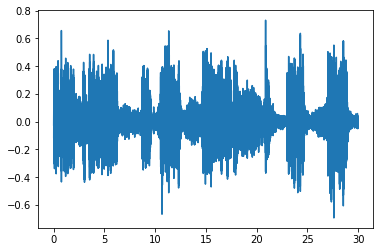

In [2]:
FILENAME_SINGLE = "audio/test_audio_single.wav"

signal_single, fs_single = torchaudio.load(FILENAME_SINGLE)
signal_single = signal_single.squeeze()

time_single = torch.linspace(0, signal_single.shape[0]/fs_single, steps=signal_single.shape[0])

plt.plot(time_single, signal_single)

Audio(FILENAME_SINGLE)

In [ ]:
VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")

In `pretrained_models/vad-crdnn-libriparty/hyperparams.yaml`, the argument `sample_rate` needs to be set to 48000 to match the resolution of the example file. Moreover, the argument `n_fft` is set to 1200 to comply with the resolution.

In [29]:
def detect_voice_activation(filename, vad):
    """
    Extracts voice activation (speech) segments from an audio file using a neural VAD model:
    Computes posterior probability for speech segments from neural VAD model.
    Applies a threshold on the posterior probability to get candidate segments.
    Extracts speech segments using energy-based VAD.
    Merges segments that are close to each other.
    Removes short segments.
    Double check the energy-based VAD using the neural VAD model.
    """
    prob_chunks = vad.get_speech_prob_file(filename)
    prob_th = vad.apply_threshold(prob_chunks, activation_th=0.5, deactivation_th=0.25).float()
    boundaries = vad.get_boundaries(prob_th)
    boundaries_energy = vad.energy_VAD(filename, boundaries, activation_th=0.8, deactivation_th=0.0)
    boundaries_merged = vad.merge_close_segments(boundaries_energy, close_th=0.250)
    boundaries_short_removed = vad.remove_short_segments(boundaries_merged, len_th=0.250)
    boundaries_checked = vad.double_check_speech_segments(boundaries_short_removed, filename,  speech_th=0.5)
    
    return [boundaries, boundaries_energy, boundaries_merged, boundaries_short_removed, boundaries_checked]

In [33]:
def plot_voice_activation(filename, vad):
    """ Plots detected voice activation (speech) segments """
    wave, fs = torchaudio.load(filename)
    signal = wave.squeeze()
    time = torch.linspace(0, signal.shape[0]/fs, steps=signal.shape[0])
    
    labels = ["Posterior", "Energy", "Merged", "Short removed", "Double-checked"]
    
    plt.plot(time, signal)
    
    for i, boundaries in enumerate(detect_voice_activation(filename, vad)):
        plt.plot(time,  VAD.upsample_boundaries(boundaries, filename).squeeze(), label=labels[i])
    
    plt.legend(loc="lower right")
    plt.show()

C:\Users\MalteLuken\Repositories\mexca-exploration\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


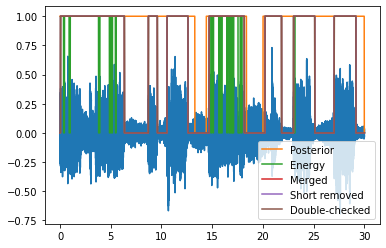

In [34]:
plot_voice_activation(FILENAME_SINGLE, VAD)

In [35]:
_, _, _, _, final_boundaries_single = detect_voice_activation(FILENAME_SINGLE, VAD)
VAD.save_boundaries(final_boundaries_single)

segment_001  0.00  0.04 NON_SPEECH
segment_002  0.04  6.34 SPEECH
segment_003  6.34  8.70 NON_SPEECH
segment_004  8.70  9.59 SPEECH
segment_005  9.59  10.54 NON_SPEECH
segment_006  10.54  12.61 SPEECH
segment_007  12.61  14.69 NON_SPEECH
segment_008  14.69  18.16 SPEECH
segment_009  18.16  20.20 NON_SPEECH
segment_010  20.20  21.83 SPEECH
segment_011  21.83  23.01 NON_SPEECH
segment_012  23.01  25.10 SPEECH
segment_013  25.10  27.02 NON_SPEECH
segment_014  27.02  29.16 SPEECH
